In [1]:
library(tidyverse)
library(speckle)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
#plots_dir <- "plots/"
#dir.create(plots_dir)
plots_dir <- "../../../paper_figures/"

In [3]:
RNA_proportions <- read.csv("01_proportion_matrix.csv", row.names = 1)
RNA_proportions <- t(RNA_proportions) # make the cell types the rows

nuclei_per_donor <- read.csv("01_nuclei_per_donor.csv", row.names = 1)
nuclei_per_donor <- nuclei_per_donor[colnames(RNA_proportions), ] # ensure metadata and nuclei per donor are same order

prop.list <- convertDataToList(RNA_proportions, data.type="proportions", 
                               transform="logit", scale.fac=nuclei_per_donor)

proportions_per_donor <- as.data.frame(prop.list$Proportions)

Performing logit transformation of proportions



### Identify outliers and mask them for plotting purposes

In [4]:
mask_outliers <- function(row) {
  Q1 <- quantile(row, 0.25)
  Q3 <- quantile(row, 0.75)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR
  upper_bound <- Q3 + 1.5 * IQR
  
  # Replace outliers with NA
  row[row < lower_bound | row > upper_bound] <- NA
  return(row)
}

In [5]:
# identify outliers
outlier_masked_proportions_per_donor <- t(apply(proportions_per_donor, 1, mask_outliers))  # transpose back to preserve structure
outlier_masked_proportions_per_donor <- as.data.frame(outlier_masked_proportions_per_donor)

In [6]:
donor_metadata <- read.csv("01_donor_level_metadata.csv", row.names = 1)

### Get the tidy version of the proportions

In [7]:
proportions_long_df <- outlier_masked_proportions_per_donor %>% rownames_to_column() %>% pivot_longer(cols = -c("rowname"), 
                                                                                       names_to = "donor_id", 
                                                                                       values_to = "proportion")
proportions_long_df <- proportions_long_df %>% left_join(donor_metadata, "donor_id")
proportions_long_df <- rename(proportions_long_df, "cell_type" = "rowname")
proportions_long_df$age_group <- factor(proportions_long_df$age_group, c("fetal", "young", "middle", "old"))

# drop NA
proportions_long_df <- proportions_long_df %>% drop_na()

### Produce the plot by age_status + disease status

In [8]:
proportions_long_df$age_disease_status <- paste0(proportions_long_df$age_status, ":", proportions_long_df$disease_binary)

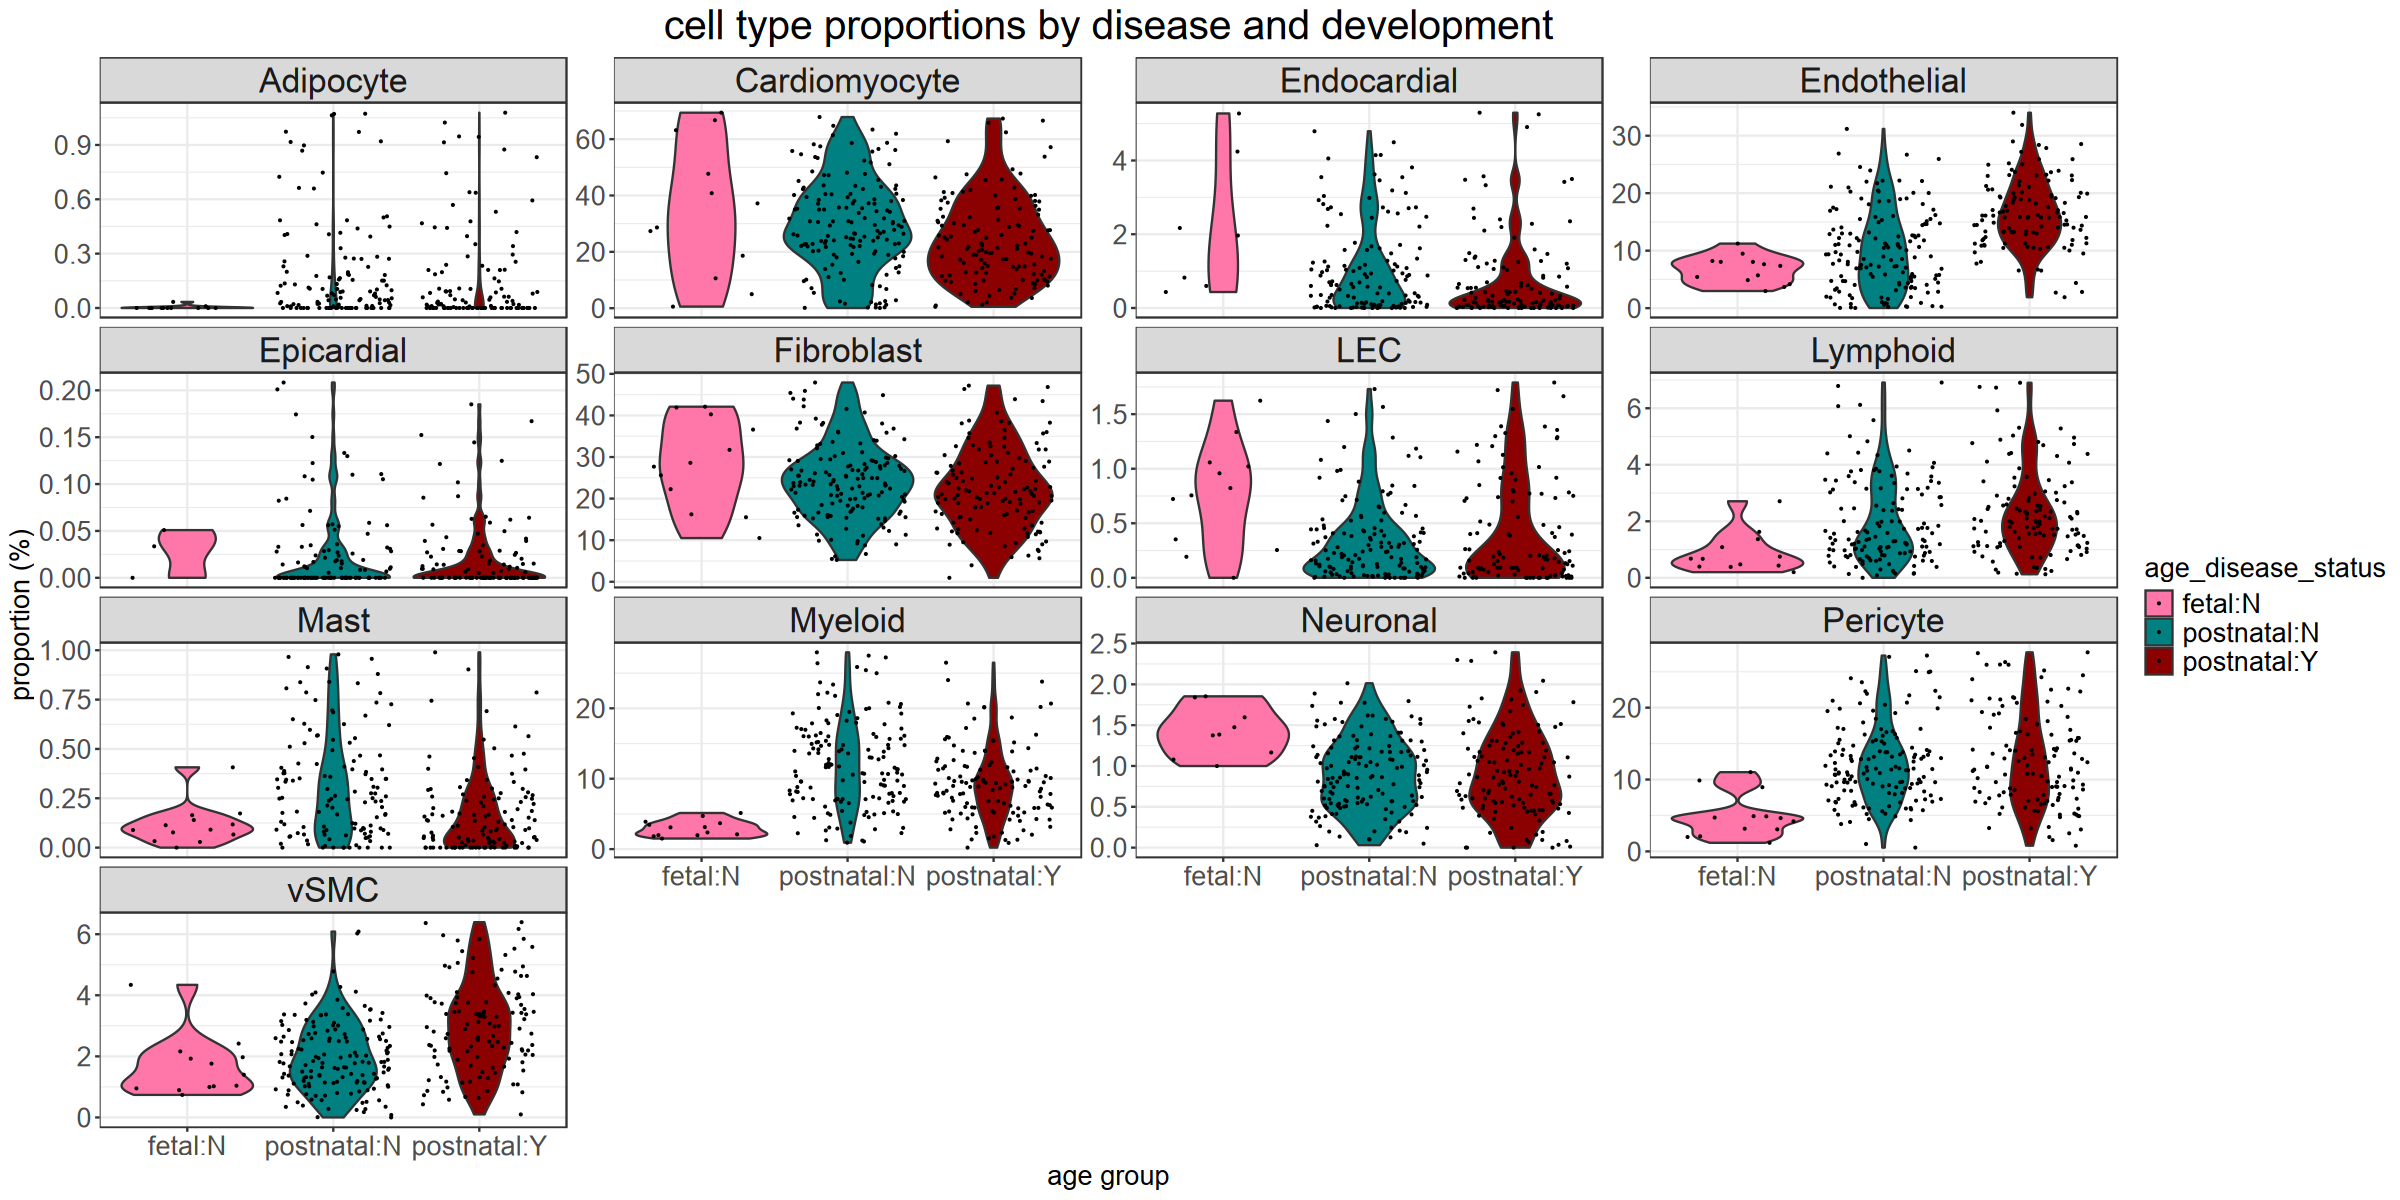

In [9]:
options(repr.plot.width = 20, repr.plot.height = 10)

p1 <- ggplot(data = proportions_long_df, mapping = aes(x = age_disease_status, y = proportion, fill = age_disease_status)) + 
geom_violin(alpha = 1) + theme_bw() + geom_jitter(size = 0.1) + facet_wrap(~cell_type, ncol = 4, scales = "free_y") + 
theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 20)) + 
scale_fill_manual(values = c("fetal:N" = "#FF77A9", 
                                 "postnatal:N" = "#008080",
                                    "postnatal:Y" = "#8B0000")) + 
    labs(x = "age group", y = "proportion (%)", title = "cell type proportions by disease and development")

p1

ggsave(plot = p1, filename = paste0(plots_dir, "cell_type_proportions_disease_facet_plot.pdf"), 
       width = 20, height = 10)

### Produce the plot separated by age group and sex

Filter to just postnatal samples

In [10]:
postnatal_proportions_long_df <- proportions_long_df %>% filter(age_group != "fetal")

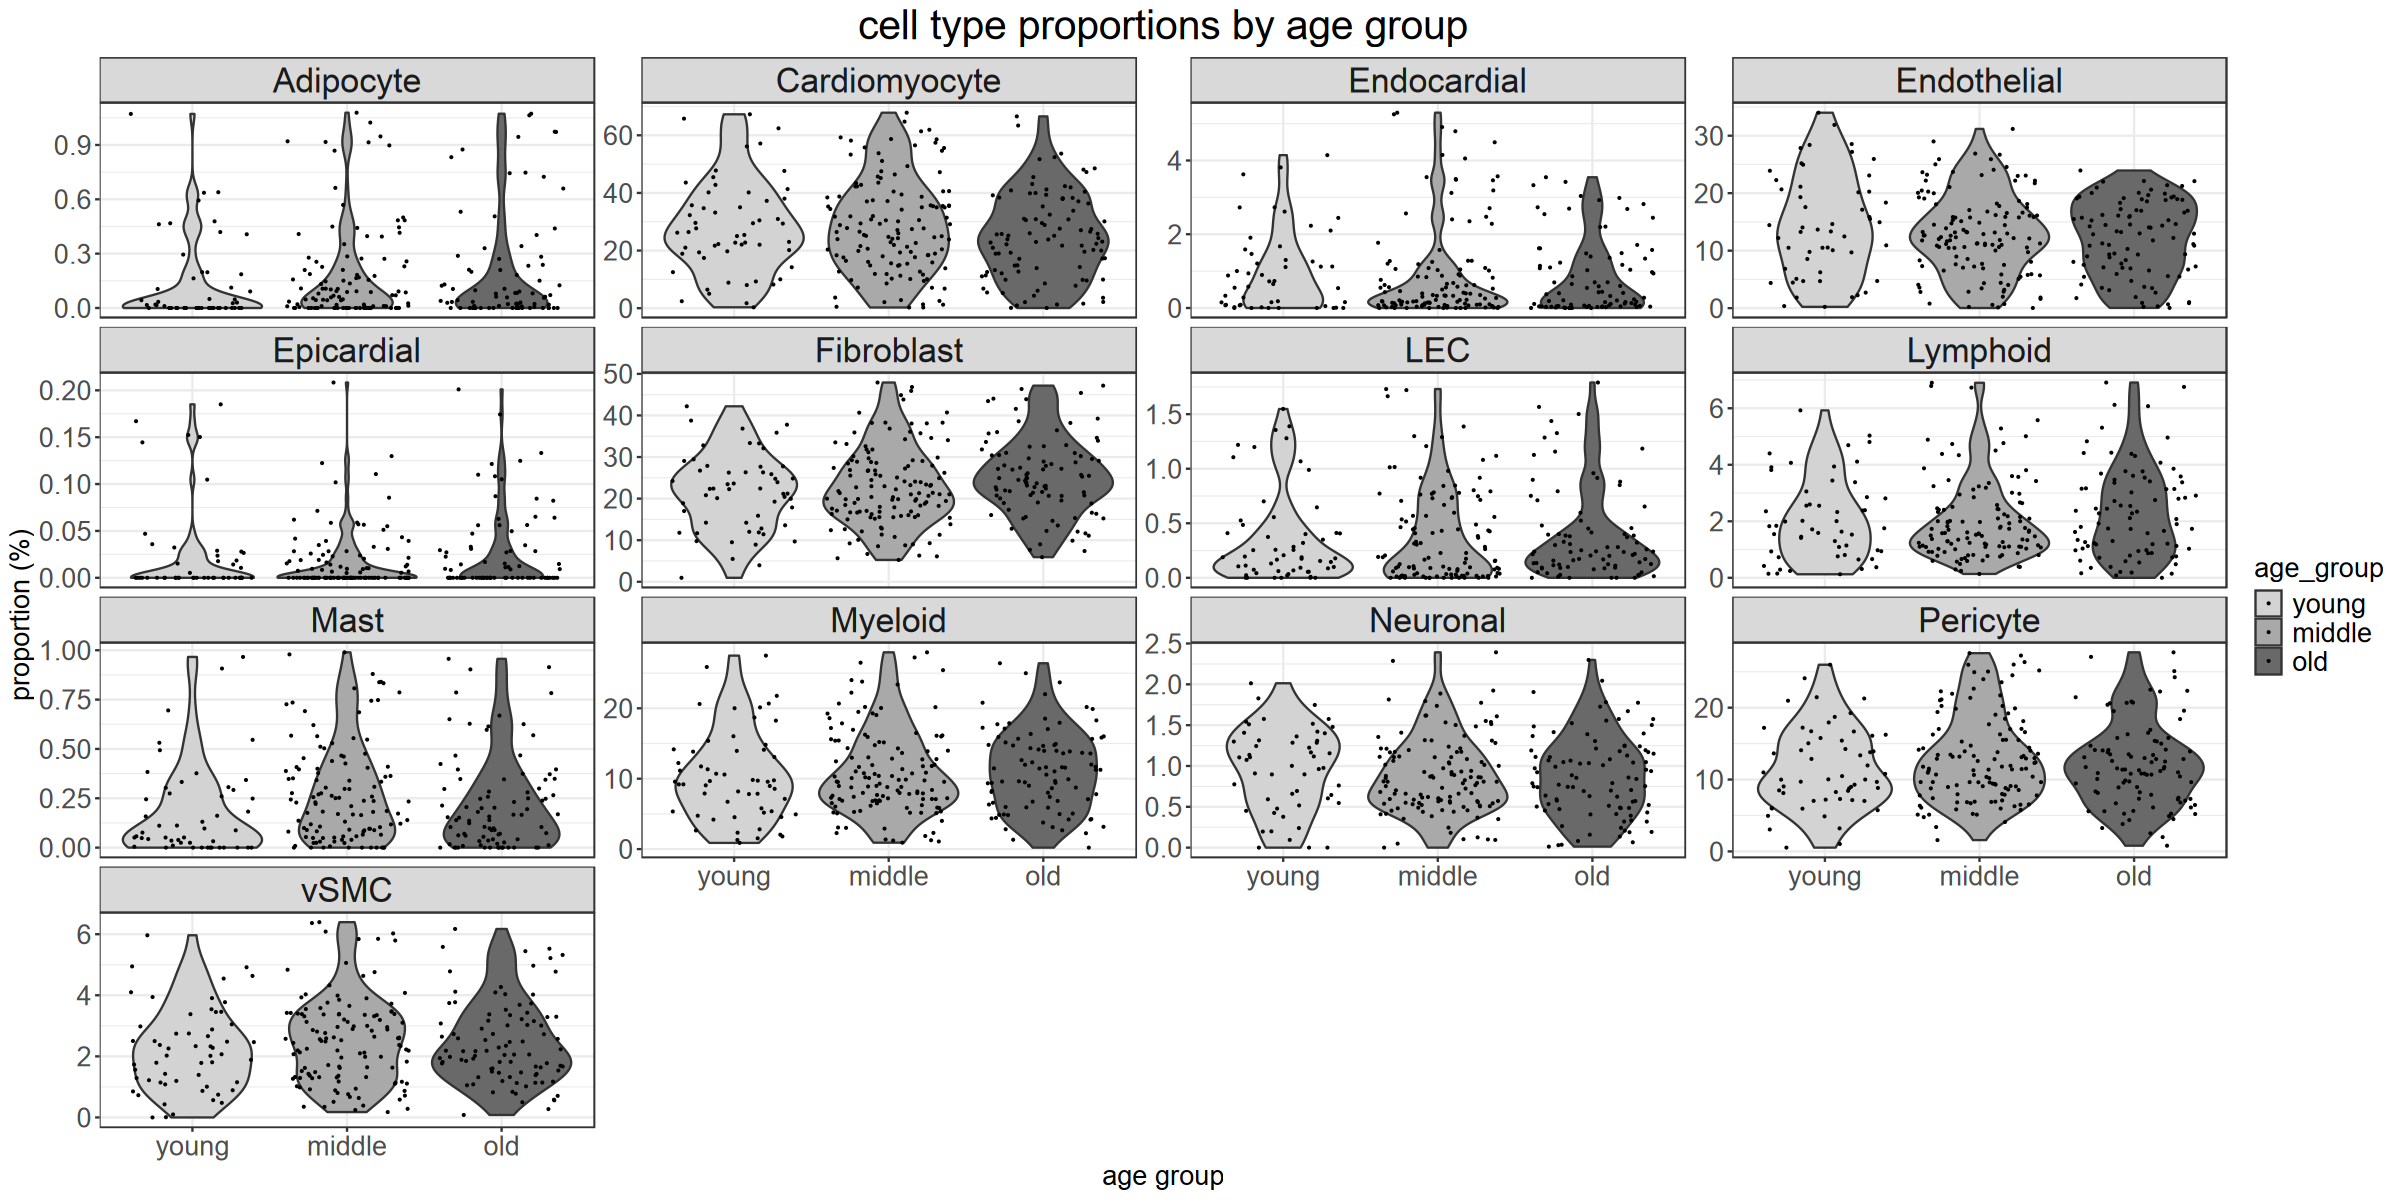

In [11]:
options(repr.plot.width = 20, repr.plot.height = 10)

p2 <- ggplot(data = postnatal_proportions_long_df, mapping = aes(x = age_group, y = proportion, fill = age_group)) + 
geom_violin(alpha = 1) + geom_jitter(size = 0.1) + theme_bw() + facet_wrap(~cell_type, ncol = 4, scales = "free_y") + 
theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 20)) + 
        scale_fill_manual(values = c("young" = "#D3D3D3", 
                                 "middle" = "#A9A9A9",
                                    "old" = "#696969")) + 
    labs(x = "age group", y = "proportion (%)", title = "cell type proportions by age group")

p2

ggsave(plot = p2, filename = paste0(plots_dir, "cell_type_proportions_age_group_facet_plot.pdf"), 
       width = 20, height = 10)

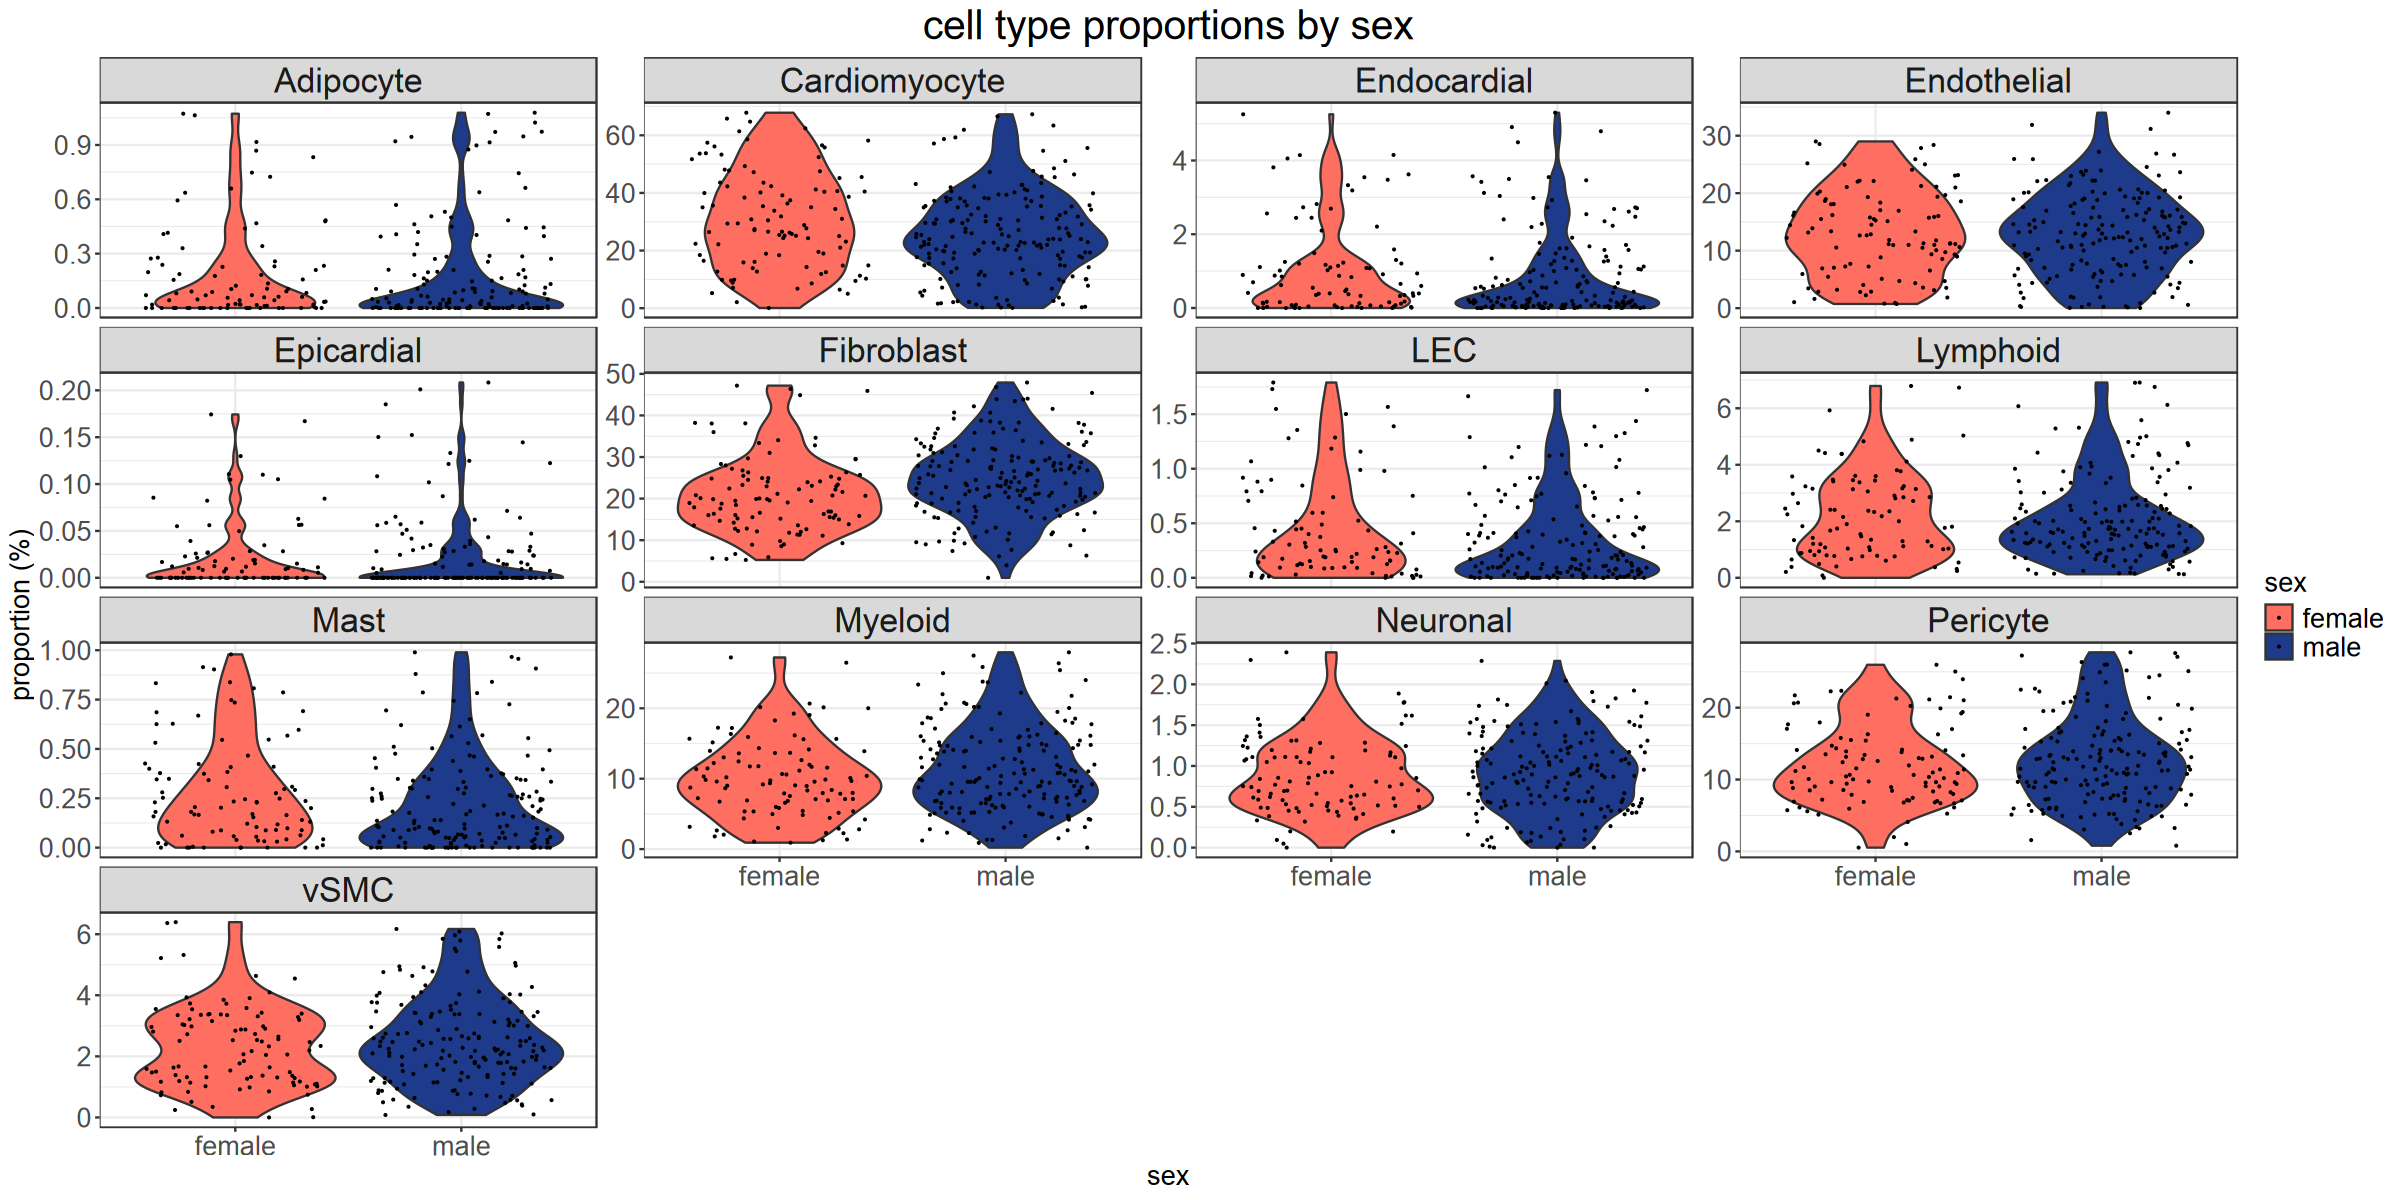

In [12]:
p3 <- ggplot(data = postnatal_proportions_long_df, mapping = aes(x = sex, y = proportion, fill = sex)) + 
geom_violin(alpha = 1) + geom_jitter(size = 0.1) + theme_bw() + facet_wrap(~cell_type, ncol = 4, scales = "free_y") +
theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 20)) + 
    scale_fill_manual(values = c("male" = "#1E3A8A", 
                                 "female" = "#FF6F61")) + 
    labs(x = "sex", y = "proportion (%)", title = "cell type proportions by sex")

p3

ggsave(plot = p3, filename = paste0(plots_dir, "cell_type_proportions_sex_facet_plot.pdf"), 
       width = 20, height = 10)